### Question 2: Life-Cycle Model with Dynamic Programming

For the law of motion we have $W + \tilde{y} = c + a$ and $W' = (1+r)a$. We may combine these and get 

$$c = W + \tilde{y} - \frac{W'}{1+r}.$$

Thus, we want to solve the following system of Bellman equations for all $t \in \{1, \dots, 60\}$ via backward induction:

$$V_t(W) = \max_{W'}\left\{ log(W + \tilde{y_t} - \frac{W'}{1+r}) + \beta V_{t+1}(W')\right\} \text{, where} \space \tilde{y_t} = \begin{cases} 
y & \text{if } t \leq 40 \\ 
0 & \text{if } 41 \leq t \leq 60.
\end{cases}$$

As preferences are monotonic, the household will choose $W' = 0$ in the terminal period $T=60$. That is, all remaining wealth is consumed in period $60$ and we have $V_{60} = log(W_{60})$ and $V_{61} = 0$. From this condition, we then start the backward induction procedure.

The following parameters are used:
- $y=0.5$
- $\beta = 0.9$
- $r=0.1$

#### 1. Solve for value & policy functions

In [23]:
# Parameters
y = 0.5               # Income during working periods
β = 0.9                 # Discount factor
r = 0.1                 # Interest rate

T1 = 40                 # Working periods
T2 = 20                 # Retirement periods
T_total = T1 + T2

# Wealth grid
N = 401
W_grid = range(-2, 6, length=N)

# Income vector
y_life_stream = [fill(0.5, T1); fill(0.0, T2)]
y_reversed = reverse(y_life_stream) # Reverse for backward induction

# Utility
function u(c)
    if c > 0
        return log(c)
    else
        return -Inf
    end
end

# Matrices
# Rows -> Time (periods left to live), Columns -> Wealth Grid Points
# Row 1 corresponds to *last* period of life (T=60)
ValueFun = zeros(T_total, N) # system of value functions
Pol_C = zeros(T_total, N)       # Policy for Consumption
Pol_W_next = zeros(T_total, N)  # Policy for Next Wealth 
Pol_W_idx = zeros(Int, T_total, N) # Policy for Next Wealth (grid index)

# Set income for terminal period
current_y = y_reversed[1]

# apply terminal condition
# ie for any wealth level, consume all as household is dead next period
for i in 1:N
    W_current = W_grid[i]
    c = W_current + current_y
    
    ValueFun[1, i] = u(c)
    Pol_C[1, i] = c
    Pol_W_next[1, i] = 0.0 # No savings after death
    # We map 0.0 to the closest index for consistency, though it doesn't matter for V
    Pol_W_idx[1, i] = findmin(abs.(W_grid .- 0.0))[2] 
end

# backward induction
for t in 2:T_total
    current_y = y_reversed[t]
    
    # Loop over all current wealth levels 
    # For each current wealth, find optimal next period wealth
    for i in 1:N
        W_current = W_grid[i]
        
        # now calculate consumption for all the possible next period wealth choices (W_next)

        resources = W_current + current_y
        save_today = W_grid ./ (1 + r)  # possible savings today to achieve W_next
        c_candidates = resources .- save_today
        
        # get utility for all candidates + discounted future value
        # we know the value function at this point from the previous iteration (ie t-1)
        val_candidates = u.(c_candidates) + β .* ValueFun[t-1, :]
        
        # now simply find the maximum value and corresponding index
        max_val, max_idx = findmax(val_candidates)

        ValueFun[t, i] = max_val
        Pol_W_idx[t, i] = max_idx
        Pol_W_next[t, i] = W_grid[max_idx]
        Pol_C[t, i] = c_candidates[max_idx]
    end
end

# reverse to normal order
V_chronological = reverse(ValueFun, dims=1)
C_chronological = reverse(Pol_C, dims=1)
W_chronological = reverse(Pol_W_next, dims=1)

60×401 Matrix{Float64}:
 -2.0  -2.0   -1.98  -1.96  -1.94  …  5.8   5.82  5.84  5.86  5.88  5.9
 -2.0  -2.0   -1.98  -1.96  -1.94     5.8   5.82  5.84  5.86  5.88  5.9
 -2.0  -2.0   -1.98  -1.96  -1.94     5.8   5.82  5.84  5.86  5.88  5.9
 -2.0  -2.0   -1.98  -1.96  -1.94     5.8   5.82  5.84  5.86  5.88  5.9
 -2.0  -2.0   -1.98  -1.96  -1.94     5.8   5.82  5.84  5.86  5.88  5.9
 -2.0  -2.0   -1.98  -1.96  -1.94  …  5.8   5.82  5.84  5.86  5.88  5.9
 -2.0  -2.0   -1.98  -1.96  -1.94     5.8   5.82  5.84  5.86  5.88  5.9
 -2.0  -2.0   -1.98  -1.96  -1.94     5.8   5.82  5.84  5.86  5.88  5.9
 -2.0  -1.98  -1.96  -1.94  -1.92     5.8   5.82  5.84  5.86  5.88  5.9
 -2.0  -1.98  -1.96  -1.94  -1.92     5.8   5.82  5.84  5.86  5.88  5.9
  ⋮                                ⋱  ⋮                             ⋮
 -2.0  -2.0   -2.0   -2.0   -2.0      5.44  5.44  5.46  5.48  5.5   5.52
 -2.0  -2.0   -2.0   -2.0   -2.0      5.36  5.36  5.38  5.4   5.42  5.44
 -2.0  -2.0   -2.0   -2.0   -2.0      5.

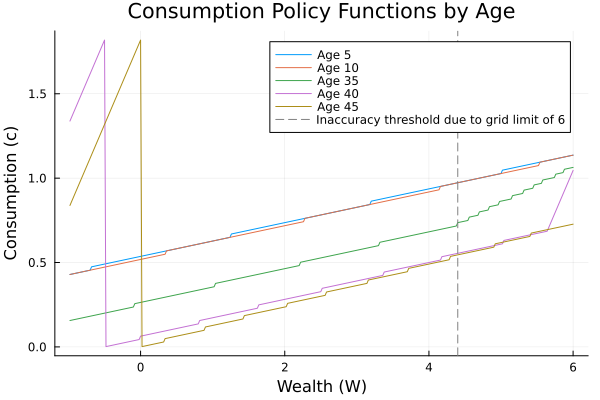

In [ ]:
using Plots

ages_to_plot = [5, 10, 35, 40, 45]

# filter for wealth > -1
W_subset = W_grid[W_grid .> -1 ]

# plot
p = plot(title = "Consumption Policy Functions by Age",
         xlabel = "Wealth (W)",
         ylabel = "Consumption (c)",
         legend = :topright
)

# Plot policy functions for ages
for age in ages_to_plot
    c_data = C_chronological[age, W_grid .> -1]
    plot!(p, W_subset, c_data, label = "Age $age")
end

# because we had to limit grid to W <= 6, we have inaccuracies for high wealth values
# the non-linearities of the policy functions for ages 35 and 40 do not sustain
# if one expands grid
vline!(p, [4.4], line=(:dash, :gray), label="Inaccuracy threshold due to grid limit of 6")

display(p)